# STM Transit Delay Data Preprocessing

## Overview

This notebook preprocesses data about STM trip updates weather and traffic, data in order to build a regression and classification model that predicts delays in seconds.

## Data Description

`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_name`: Name of the stop.<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_distance`: Distance between the previous and current stop, in meters.<br>
`stop_sequence`: Sequence of the stop, for ordering.<br>
`trip_progress`: How far along the trip is the vehicle, from 0 (first stop) to 1 (last stop).<br>
`stop_has_alert`: Indicates if there's a message about the stop being moved or cancelled.<br>
`schedule_relationship`: State of the schedule: "scheduled", "skipped" or "no data".
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair.<br>
`rt_arrival_time`, `rt_departure_time`, `sch_arrival_time`, `sch_departure_time`: Realtime and scheduled times, in UTC.<br>
`delay`: Difference between real and scheduled arrival time, in seconds<br>
`delay_class`: Delay category, from early to late<br>
`incident_count`: Number of incidents within 500 meters of the stop.<br>
`incident_nearby`: Indicates if an incident happened within 500 meters of the stop.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>

## Imports

In [ ]:
from kneed import KneeLocator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import sys

In [18]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import DELAY_CLASS, LOCAL_TIMEZONE, OCCUPANCY_STATUS

In [3]:
# Load data
df = pd.read_parquet('../data/stm_weather_traffic_merged.parquet')

## Data Preprocessing

### Handle Delay Outliers

In [4]:
df['delay'].describe()

count    2.222766e+06
mean     5.570522e+01
std      3.582895e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.458500e+04
Name: delay, dtype: float64

In [5]:
# Compute mean and standard deviation
mean_delay = df['delay'].mean()
std_delay = df['delay'].std()

In [6]:
# Filter outliers based on standard deviation
outlier_mask = (df['delay'] < mean_delay - 3 * std_delay) | (df['delay'] > mean_delay + 3 * std_delay)

In [7]:
# Get proportion of outliers
print(f'{outlier_mask.mean():.2%}')

0.80%


In [8]:
# Remove outliers
df = df[~outlier_mask].reset_index(drop=True)

In [9]:
# Get new distribution
df['delay'].describe()

count    2.205086e+06
mean     4.368318e+01
std      1.447935e+02
min     -1.017000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.130000e+03
Name: delay, dtype: float64

### Encode Datetime

In [10]:
# Convert scheduled arrival time
df['sch_arrival_time'] = pd.to_datetime(df['sch_arrival_time'], utc=True).dt.tz_convert(LOCAL_TIMEZONE)

In [11]:
# Convert datetime to month, day and hour
df['month'] = df['sch_arrival_time'].dt.month
df['day_of_week'] = df['sch_arrival_time'].dt.day_of_week
df['hour'] = df['sch_arrival_time'].dt.hour

In [12]:
# Add boolean value is_weekend
weekend_mask = df['day_of_week'].isin([5, 6])
df['is_weekend'] = np.where(weekend_mask, 1, 0)

In [13]:
# Add boolean value is_peak_hour (weekdays from 7-9am or 4-6pm)
peak_hour_mask = (weekend_mask == False) & (df['hour'].isin([7, 8, 9, 16, 17, 18]))
df['is_peak_hour'] = np.where(peak_hour_mask, 1, 0)

In [14]:
# Drop datetime columns
df = df.drop(['rt_arrival_time', 'rt_departure_time', 'sch_arrival_time', 'sch_departure_time'], axis=1)

### Use Label Encoding for route_id and stop_id

In [15]:
le_vehicle = LabelEncoder()
df['vehicle_id'] = le_vehicle.fit_transform(df['vehicle_id'])

In [16]:
le_route = LabelEncoder()
df['route_id'] = le_route.fit_transform(df['route_id'])

In [17]:
le_stop = LabelEncoder()
df['stop_id'] = le_stop.fit_transform(df['stop_id'])

### Use Ordinal Encoding for delay_class and occupancy_status

In [19]:
delay_map = {value: key for (key, value) in DELAY_CLASS.items()}
df['delay_class'] = df['delay_class'].map(delay_map).astype('int64')
df['delay_class'].value_counts(normalize=True)

delay_class
1    0.871433
2    0.105529
0    0.023039
Name: proportion, dtype: float64

In [20]:
occ_map = {value: key for (key, value) in OCCUPANCY_STATUS.items()}
df['occupancy_status'] = df['occupancy_status'].map(occ_map)
df['occupancy_status'].value_counts(normalize=True)

occupancy_status
1    0.479640
2    0.298400
3    0.206486
5    0.014779
0    0.000695
Name: proportion, dtype: float64

### Use One Hot Encoding Schedule Relationship

In [25]:
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    2184212
No Data        12069
Skipped         8805
Name: count, dtype: int64

In [ ]:
# Use One Hot Encoding
one_hot = pd.get_dummies(df['schedule_relationship'], drop_first=True, dtype='int64', prefix='sch_rel')
df = df.join(one_hot).drop('schedule_relationship', axis=1)

### Use K-Means to group weather conditions

### Drop redundant/unnecessary columns


In [ ]:
# Get remaining string columns
df.select_dtypes(include='object').columns

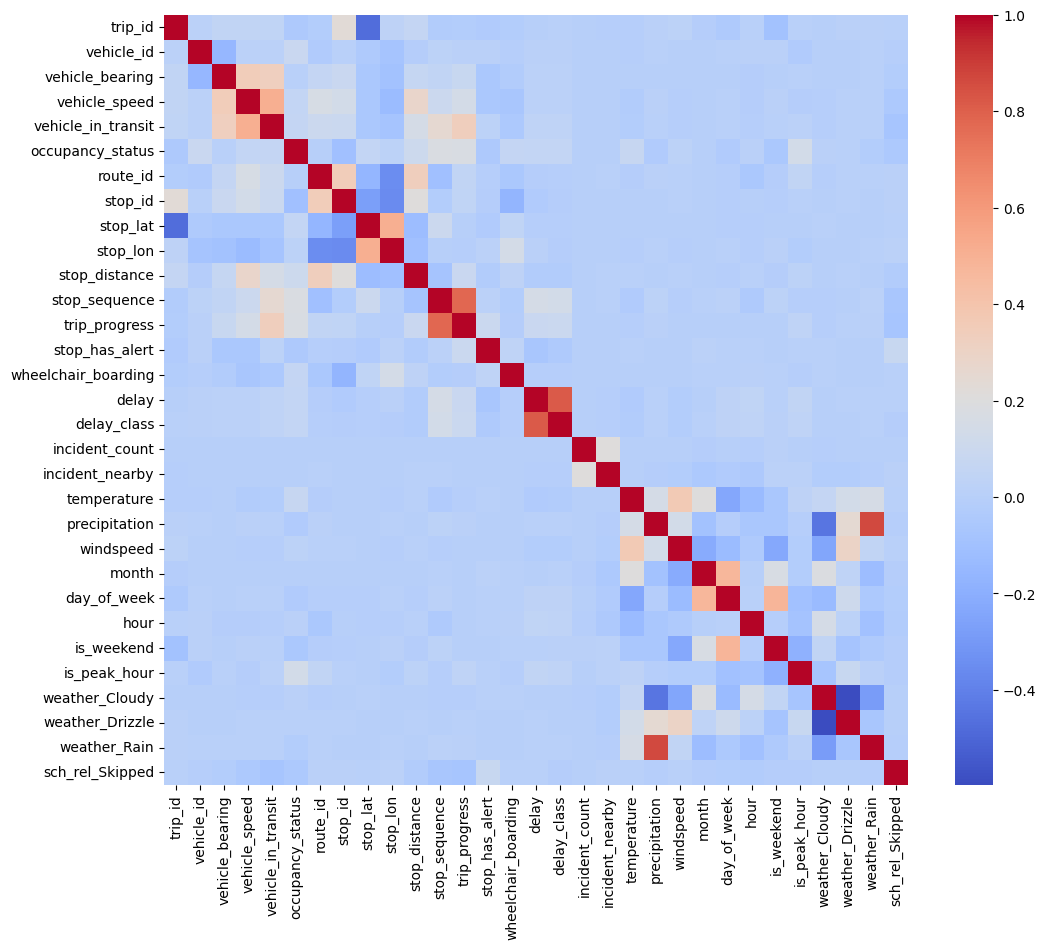

In [28]:
# Check for highly correlated features
corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm')
plt.show()

`trip_id`: Identifies a vehicle on a specific day and might cause data leakage.<br>
`stop_lat`, `stop_lon`, `stop_name`: The location is already encoded with the the stop_id.<br>
`stop_sequence`: The trip progress has been calculated.<br>
`weather_Rain`: It's redundant with precipitation.<br>
`weather_Drizzle`: It's highly correlated with weather_Cloudy<br>

In [29]:
df = df.drop([
  'trip_id',
  'stop_lat',
  'stop_lon',
  'stop_name',
  'stop_sequence',
  'weather_Drizzle',
  'weather_Rain'], axis=1)

## Export Data

In [30]:
df.columns

Index(['vehicle_id', 'vehicle_bearing', 'vehicle_speed', 'vehicle_in_transit',
       'occupancy_status', 'route_id', 'stop_id', 'stop_distance',
       'trip_progress', 'stop_has_alert', 'wheelchair_boarding', 'delay',
       'delay_class', 'incident_count', 'incident_nearby', 'temperature',
       'precipitation', 'windspeed', 'month', 'day_of_week', 'hour',
       'is_weekend', 'is_peak_hour', 'weather_Cloudy', 'sch_rel_Skipped'],
      dtype='object')

In [31]:
# Reorder columns
df = df[[
  		'vehicle_id',
    	'vehicle_bearing',
    	'vehicle_speed',
    	'vehicle_in_transit',
       	'occupancy_status',
		'route_id',
		'stop_id',
		'stop_distance',
		'trip_progress',
    	'stop_has_alert',
       	'sch_rel_Skipped',
		'wheelchair_boarding',
    	'month',
		'day_of_week',
    	'hour',
    	'is_weekend',
       	'is_peak_hour',
		'incident_count',
		'incident_nearby',
		'temperature',
		'precipitation',
		'windspeed',
		'weather_Cloudy',
    	'delay',
       	'delay_class',
]]

In [32]:
# Assert all columns are numeric
assert len(df.columns) == len(df.select_dtypes([np.number]).columns)

In [33]:
# Export encoders
encoders = {
	'le_vehicle': le_vehicle,
  	'le_route': le_route,
  	'le_stop': le_stop,
}

with open('../models/label_encoders.pkl', 'wb') as handle:
	pickle.dump(encoders, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [35]:
# Export dataframe
df.to_parquet('../data/preprocessed.parquet', index=False)

## End